## Tut Implementation (bulk water viscosity determination)

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

mpl.rc('figure',  figsize=(10, 5))
mpl.rc('image', cmap='gray')

In [3]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series  
import pims
import trackpy as tp

In [4]:
@pims.pipeline
def gray(image):
    return image[:, :, 1]  # Take just the green channel

frames = gray(pims.open('/mnt/d/Research Projects/others/Viscosity model/trackpy-examples-master/trackpy-examples-master/sample_data/bulk_water/*.png'))

In [5]:
frames

(ImageSequence,) processed through proc_func. Original repr:
    <Frames>
    Source: /mnt/d/Research Projects/others/Viscosity model/trackpy-examples-master/trackpy-examples-master/sample_data/bulk_water/*.png
    Length: 300 frames
    Frame Shape: (424, 640, 4)
    Pixel Datatype: uint8

In [6]:
print(frames[0])  # the first frame

[[125 125 125 ... 120 120 121]
 [125 125 125 ... 120 121 121]
 [125 125 124 ... 121 123 124]
 ...
 [125 126 125 ... 108  98  97]
 [125 125 125 ... 116 109 106]
 [125 125 125 ... 124 119 117]]


Frame([[125, 125, 125, ..., 120, 120, 121],
       [125, 125, 125, ..., 120, 121, 121],
       [125, 125, 124, ..., 121, 123, 124],
       ...,
       [125, 126, 125, ..., 108,  98,  97],
       [125, 125, 125, ..., 116, 109, 106],
       [125, 125, 125, ..., 124, 119, 117]], dtype=uint8)
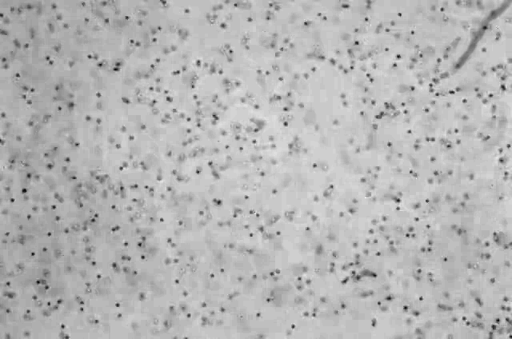

In [7]:
frames[0]

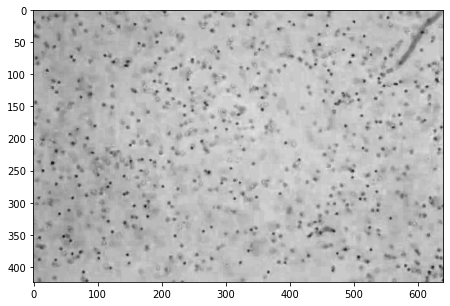

In [8]:
plt.imshow(frames[0]);

In [9]:
frames[123].frame_no

123

In [10]:
frames[123].metadata  # Scientific formats can pass experiment meta data here.

{}

In [11]:
f = tp.locate(frames[0], 11, invert=True)

In [12]:
f.head()  # shows the first few rows of data

,y,x,mass,size,ecc,signal,raw_mass,ep,frame
0,4.750000,103.668564,192.862485,2.106615,0.066390,10.808405,10714.0,0.073666,0
1,5.249231,585.779487,164.659302,2.962674,0.078936,4.222033,10702.0,0.075116,0
2,5.785986,294.792544,244.624615,2.244542,0.219217,15.874846,10686.0,0.077141,0
3,5.869369,338.173423,187.458282,2.046201,0.185333,13.088304,10554.0,0.099201,0
4,6.746377,310.584169,151.486558,3.103294,0.053342,4.475355,10403.0,0.147430,0


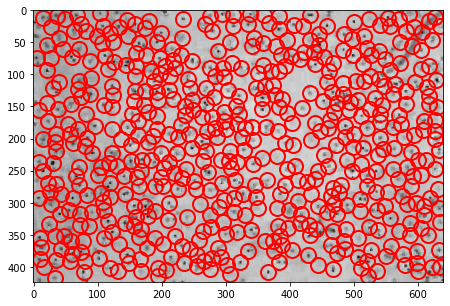

In [13]:
tp.annotate(f, frames[0]);

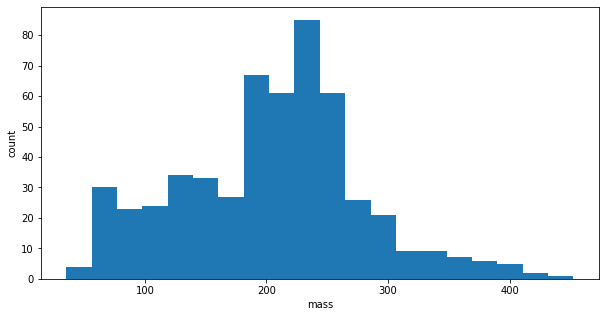

In [14]:
fig, ax = plt.subplots()
ax.hist(f['mass'], bins=20)

# Optionally, label the axes.
ax.set(xlabel='mass', ylabel='count');

In [15]:
f = tp.locate(frames[0], 11, invert=True, minmass=20)


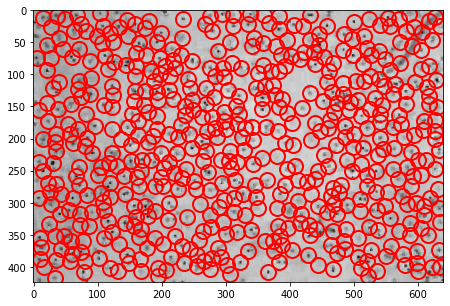

In [16]:
tp.annotate(f, frames[0]);


array([[<Axes: title={'center': 'x'}>, <Axes: title={'center': 'y'}>]],
      dtype=object)

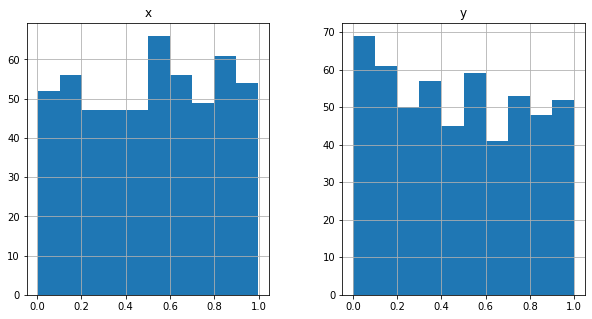

In [17]:
tp.subpx_bias(f)


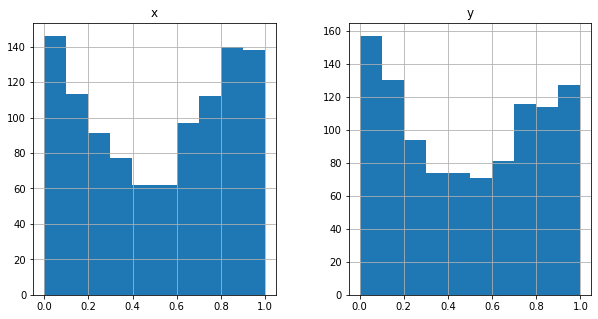

In [18]:
tp.subpx_bias(tp.locate(frames[0], 7, invert=True, minmass=20));


In [19]:
f = tp.batch(frames[:300], 11, minmass=20, invert=True);


Frame 299: 624 features


In [20]:
# tp.quiet()  # Turn off progress reports for best performance
t = tp.link(f, 5, memory=3)

Frame 299: 624 trajectories present.


In [21]:
t.head()


,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle
0,4.750000,103.668564,192.862485,2.106615,0.066390,10.808405,10714.0,0.073666,0,0
365,284.118980,25.313881,149.037779,2.321961,0.031799,7.008575,10770.0,0.067577,0,1
364,282.753601,534.788476,222.754482,1.908443,0.103416,15.874846,10415.0,0.141946,0,2
363,280.010398,275.185353,186.782757,2.508665,0.183181,7.261897,10438.0,0.132499,0,3
362,279.134153,252.780324,151.064355,2.938060,0.253812,4.306474,10359.0,0.171764,0,4


In [22]:
t1 = tp.filter_stubs(t, 25)
# Compare the number of particles in the unfiltered and filtered data.
print('Before:', t['particle'].nunique())
print('After:', t1['particle'].nunique())

Before: 13715
After: 1505


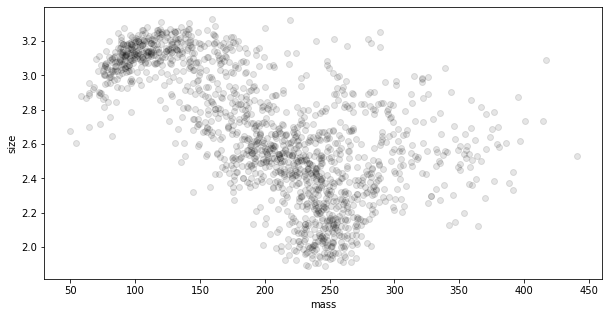

In [23]:
plt.figure()
tp.mass_size(t1.groupby('particle').mean()); # convenience function -- just plots size vs. mass

In [24]:
t2 = t1[((t1['mass'] > 50) & (t1['size'] < 2.6) &
         (t1['ecc'] < 0.3))]

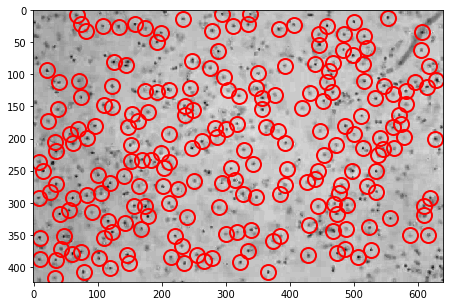

In [25]:
plt.figure()
tp.annotate(t2[t2['frame'] == 0], frames[0]);

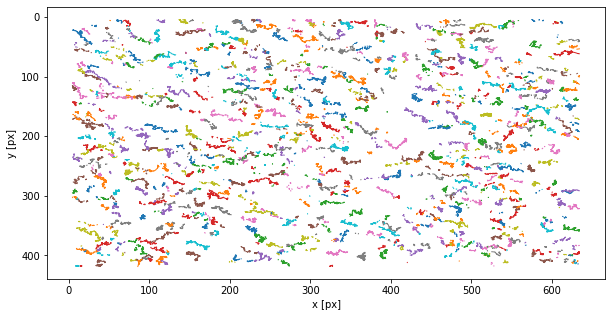

In [26]:
plt.figure()
tp.plot_traj(t2);

In [27]:
d = tp.compute_drift(t2)


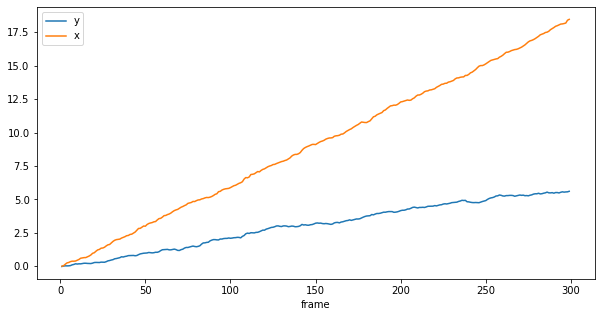

In [28]:
d.plot()
plt.show()

In [29]:
tm = tp.subtract_drift(t2.copy(), d)


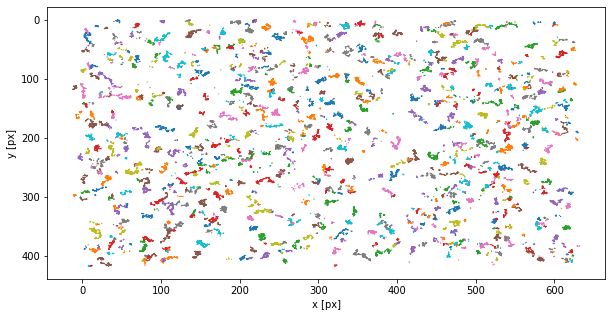

In [30]:
ax = tp.plot_traj(tm)
plt.show()

In [31]:
im = tp.imsd(tm, 100/285., 24)  # microns per pixel = 100/285., frames per second = 24


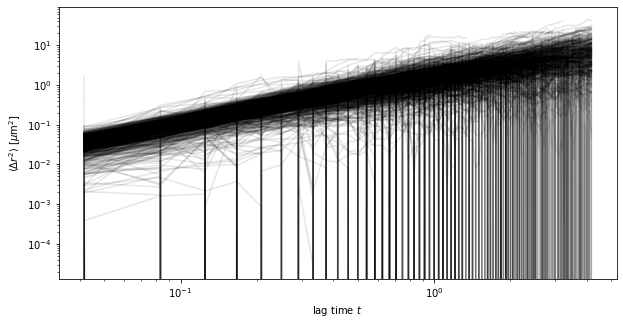

In [32]:
fig, ax = plt.subplots()
ax.plot(im.index, im, 'k-', alpha=0.1)  # black lines, semitransparent
ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]',
       xlabel='lag time $t$')
ax.set_xscale('log')
ax.set_yscale('log')

In [33]:
em = tp.emsd(tm, 100/285., 24) # microns per pixel = 100/285., frames per second = 24

/home/berserker/.local/lib/python3.10/site-packages/trackpy/motion.py:235: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  results = msds.mul(msds['N'], axis=0).mean(level=1)  # weighted average
/home/berserker/.local/lib/python3.10/site-packages/trackpy/motion.py:236: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  results = results.div(msds['N'].mean(level=1), axis=0)  # weights normalized


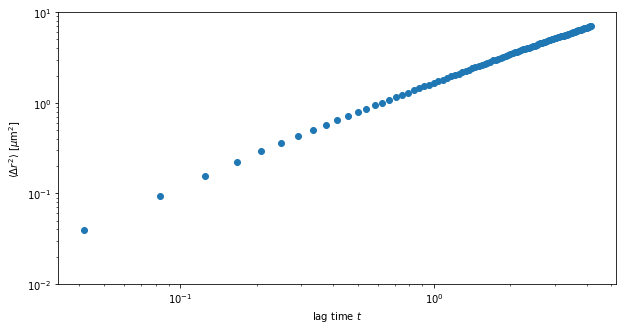

In [34]:
fig, ax = plt.subplots()
ax.plot(em.index, em, 'o')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]',
       xlabel='lag time $t$')
ax.set(ylim=(1e-2, 10));

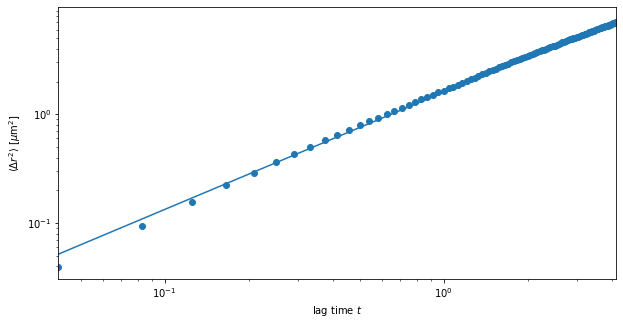

,n,A
msd,1.0787,1.595089


In [35]:
plt.figure()
plt.ylabel(r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]')
plt.xlabel('lag time $t$');
tp.utils.fit_powerlaw(em)  # performs linear best fit in log space, plots]

## Dilute milk viscosity determination

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

mpl.rc('figure',  figsize=(10, 5))
mpl.rc('image', cmap='gray')

In [2]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series  
import pims
import trackpy as tp

In [5]:
@pims.pipeline
def gray(image):
    return image[:, :, 1]  # Take just the green channel

frames = gray(pims.open('/mnt/d/Research Projects/others/viscosity using trackpy/milk_images/*.jpg'))

In [6]:
frames

(ImageSequence,) processed through proc_func. Original repr:
    <Frames>
    Source: /mnt/d/Research Projects/others/viscosity using trackpy/milk_images/*.jpg
    Length: 154 frames
    Frame Shape: (284, 384, 3)
    Pixel Datatype: uint8

In [7]:
print(frames[0])  # the first frame

[[241 166 173 ... 176 177 176]
 [187 154 183 ... 176 176 176]
 [167 179 208 ... 175 175 177]
 ...
 [180 186 182 ... 181 181 184]
 [180 186 183 ... 180 180 182]
 [181 187 183 ... 110 109 111]]


Frame([[241, 166, 173, ..., 176, 177, 176],
       [187, 154, 183, ..., 176, 176, 176],
       [167, 179, 208, ..., 175, 175, 177],
       ...,
       [180, 186, 182, ..., 181, 181, 184],
       [180, 186, 183, ..., 180, 180, 182],
       [181, 187, 183, ..., 110, 109, 111]], dtype=uint8)
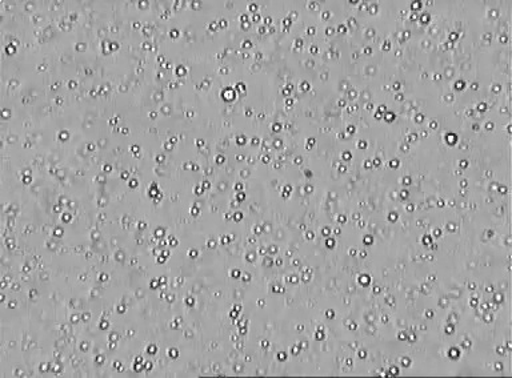

In [8]:
frames[0]

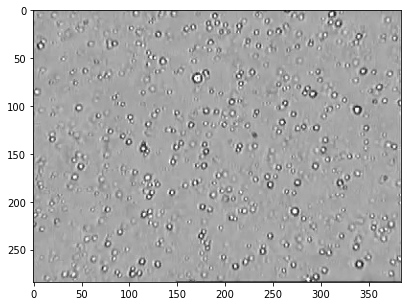

In [9]:
plt.imshow(frames[0]);

In [10]:
frames[123].frame_no

123

In [11]:
frames[123].metadata  # Scientific formats can pass experiment meta data here.

{}

In [12]:
f = tp.locate(frames[0], 11, invert=True)

In [13]:
f.head()  # shows the first few rows of data

,y,x,mass,size,ecc,signal,raw_mass,ep,frame
0,5.496265,5.091782,226.761361,2.562558,0.377608,15.972518,6151.0,-0.246481,0
1,5.122547,280.838200,505.554410,2.788714,0.110153,29.040943,6477.0,-0.271824,0
2,12.542531,67.657676,233.295573,3.103171,0.432896,10.164330,6241.0,-0.252993,0
3,10.809389,368.311652,427.869889,3.264716,0.200269,19.118621,6088.0,-0.242119,0
4,12.660873,54.586898,543.065628,2.203141,0.185910,31.703029,6576.0,-0.280586,0


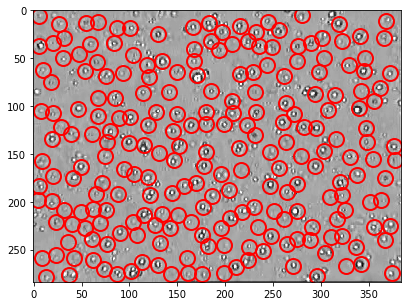

In [14]:
tp.annotate(f, frames[0]);

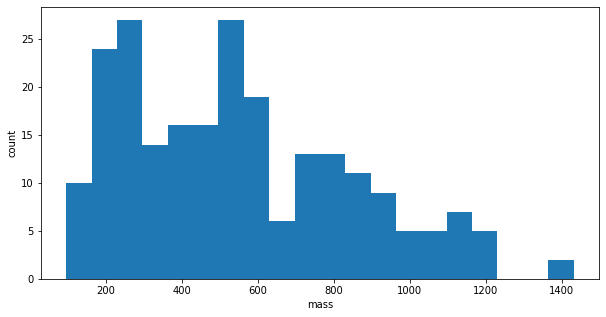

In [15]:
fig, ax = plt.subplots()
ax.hist(f['mass'], bins=20)

# Optionally, label the axes.
ax.set(xlabel='mass', ylabel='count');

In [16]:
f = tp.locate(frames[0], 11, invert=True, minmass=20)

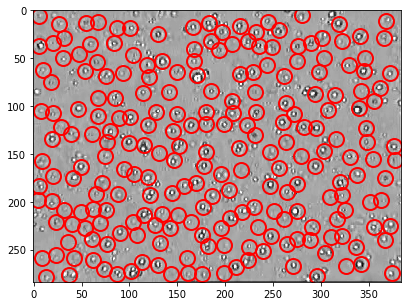

In [17]:
tp.annotate(f, frames[0]);

array([[<Axes: title={'center': 'x'}>, <Axes: title={'center': 'y'}>]],
      dtype=object)

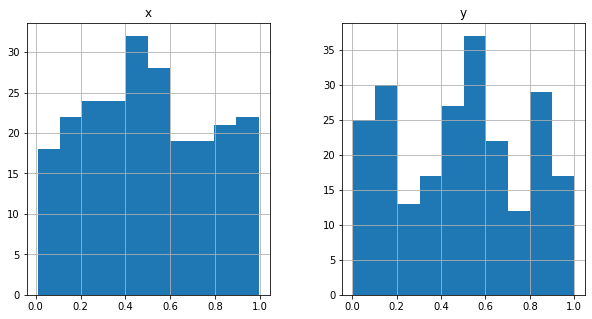

In [18]:
tp.subpx_bias(f)

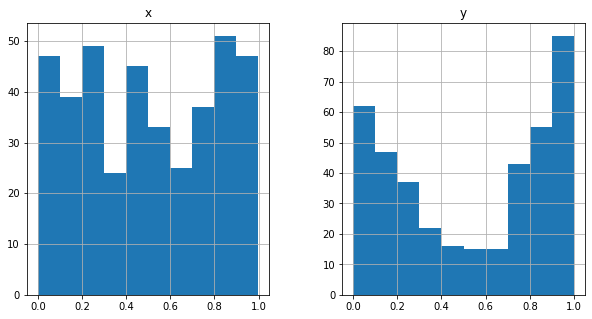

In [19]:
tp.subpx_bias(tp.locate(frames[0], 7, invert=True, minmass=20));

In [20]:
f = tp.batch(frames[:154], 11, minmass=20, invert=True);

Frame 153: 216 features


In [21]:
# tp.quiet()  # Turn off progress reports for best performance
t = tp.link(f, 5, memory=3)

Frame 153: 216 trajectories present.


In [22]:
t.head()

,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle
0,5.496265,5.091782,226.761361,2.562558,0.377608,15.972518,6151.0,-0.246481,0,0
146,189.986148,264.639842,366.883909,2.508429,0.251687,22.264723,6282.0,-0.256075,0,1
147,191.534643,65.210962,234.021596,2.240919,0.083756,17.908581,6302.0,-0.257606,0,2
148,192.272083,88.427019,512.330630,3.309139,0.246523,21.054683,6591.0,-0.281963,0,3
149,192.554743,121.933604,893.008987,3.019629,0.085234,45.255469,7182.0,-0.349550,0,4


In [23]:
t1 = tp.filter_stubs(t, 25)
# Compare the number of particles in the unfiltered and filtered data.
print('Before:', t['particle'].nunique())
print('After:', t1['particle'].nunique())

Before: 2269
After: 342


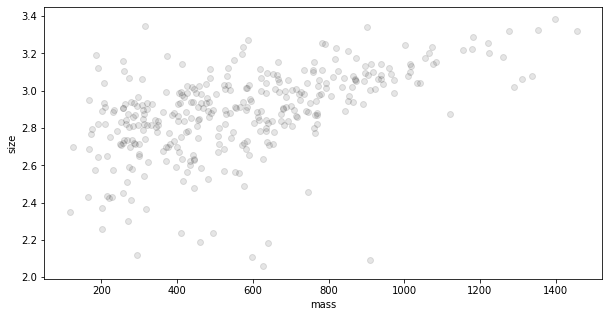

In [24]:
plt.figure()
tp.mass_size(t1.groupby('particle').mean()); # convenience function -- just plots size vs. mass

In [33]:
t2 = t1

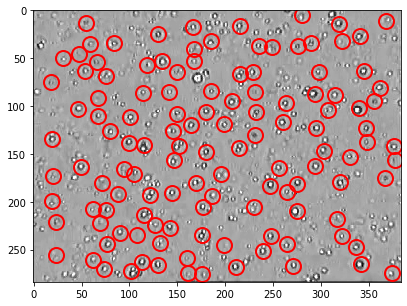

In [34]:
plt.figure()
tp.annotate(t2[t2['frame'] == 0], frames[0]);

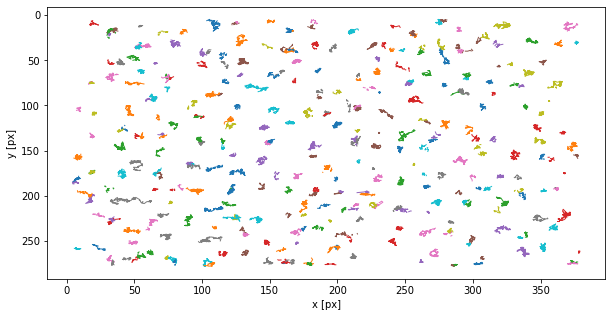

In [35]:
plt.figure()
tp.plot_traj(t2);

In [36]:
d = tp.compute_drift(t2)

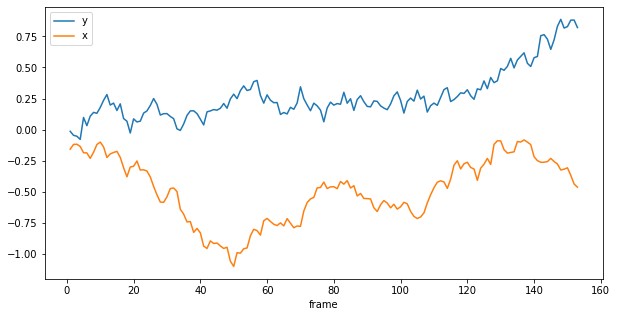

In [37]:
d.plot()
plt.show()

In [38]:
tm = tp.subtract_drift(t2.copy(), d)

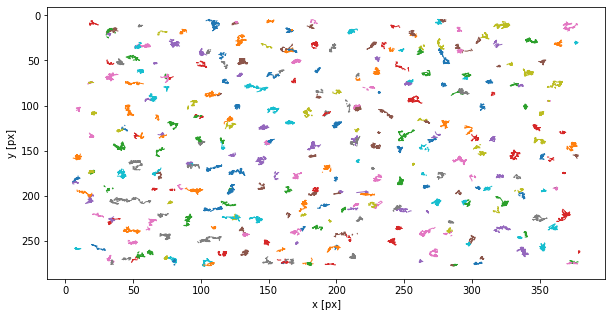

In [39]:
ax = tp.plot_traj(tm)
plt.show()

In [40]:
im = tp.imsd(tm, 100/285., 24)  # microns per pixel = 100/285., frames per second = 24

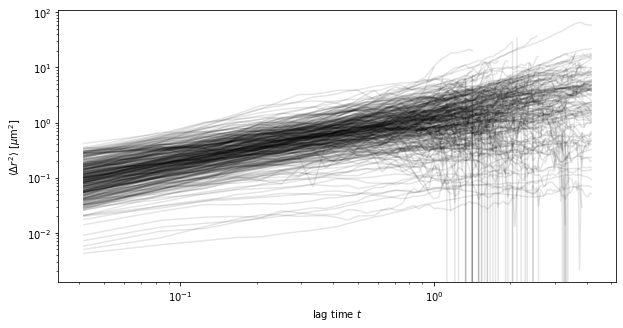

In [41]:
fig, ax = plt.subplots()
ax.plot(im.index, im, 'k-', alpha=0.1)  # black lines, semitransparent
ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]',
       xlabel='lag time $t$')
ax.set_xscale('log')
ax.set_yscale('log')

In [42]:
em = tp.emsd(tm, 100/285., 24) # microns per pixel = 100/285., frames per second = 24

/home/berserker/.local/lib/python3.10/site-packages/trackpy/motion.py:235: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  results = msds.mul(msds['N'], axis=0).mean(level=1)  # weighted average
/home/berserker/.local/lib/python3.10/site-packages/trackpy/motion.py:236: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  results = results.div(msds['N'].mean(level=1), axis=0)  # weights normalized


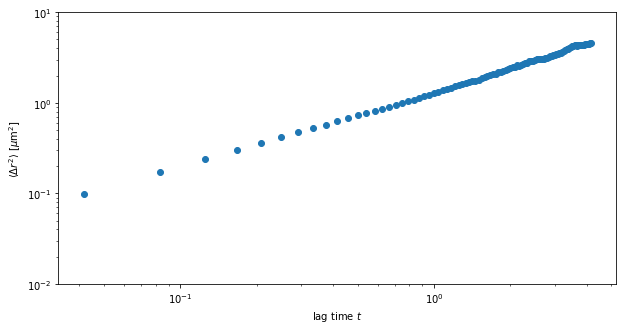

In [43]:
fig, ax = plt.subplots()
ax.plot(em.index, em, 'o')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]',
       xlabel='lag time $t$')
ax.set(ylim=(1e-2, 10));

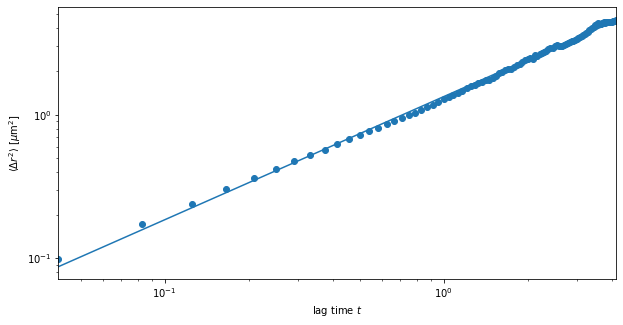

,n,A
msd,0.857318,1.335632


In [44]:
plt.figure()
plt.ylabel(r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]')
plt.xlabel('lag time $t$');
tp.utils.fit_powerlaw(em)  # performs linear best fit in log space, plots]